# Pareto-NBD model

Comparison with lifetimes



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import warnings

In [2]:
from pymc_marketing.clv.distributions import ParetoNBD

In [3]:
# Extra dependency for this notebook
from lifetimes.datasets import load_cdnow_summary
from lifetimes import ParetoNBDFitter

## Load data

In [4]:
df = load_cdnow_summary(index_col=[0])
df.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


In [5]:
df.shape

(2357, 3)

In [6]:
x = df["frequency"].values
t_x = df["recency"].values
T = df["T"].values

## Lifetimes implementation

In [7]:
ParetoNBDFitter().fit(x, t_x, T)

<lifetimes.ParetoNBDFitter: fitted with 2357 subjects, alpha: 10.58, beta: 11.67, r: 0.55, s: 0.61>

In [8]:
fit = {"r": 0.55, "alpha": 10.58, "s": 0.61, "beta": 11.67}

In [9]:
ParetoNBDFitter._conditional_log_likelihood(list(fit.values()), x, t_x, T).sum()

-9595.008530490335

## PyMC-Marketing Implementation

In [10]:
np.stack((t_x, x), axis=1).shape

(2357, 2)

In [11]:
with pm.Model() as m1:
    r = pm.HalfNormal("r")
    alpha = pm.HalfNormal("alpha", sigma=5)
    s = pm.HalfNormal("s")
    beta = pm.HalfNormal("beta", sigma=5)
    llike = ParetoNBD("llike", r=r, alpha=alpha, s=s, beta=beta, T=T, observed=np.stack((t_x, x), axis=1))

In [12]:
pm.logp(llike, np.stack((t_x, x), axis=1)).sum().eval(dict(zip((r, alpha, s, beta), fit.values())))

/home/ricardo/miniconda3/envs/pymmmc/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/ricardo/miniconda3/envs/pymmmc/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:762: UserWarning: Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/ricardo/miniconda3/envs/pymmmc/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/ricardo/miniconda3/envs/pymmmc/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:762: UserWarning: Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as bein

array(-9595.00853049)

In [13]:
# with m1:
#     with warnings.catch_warnings():
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         idata = pm.sample(initvals=fit)  # jitter leads to points where gradient does not converge, takes ages to sample
#         idata = pm.sample(initvals=fit, init="adapt_diag")  # still takes ages to sample

In [14]:
with m1:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )        
        
        idata = pm.sample(initvals=fit, step=pm.Slice())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [r]
>Slice: [alpha]
>Slice: [s]
>Slice: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


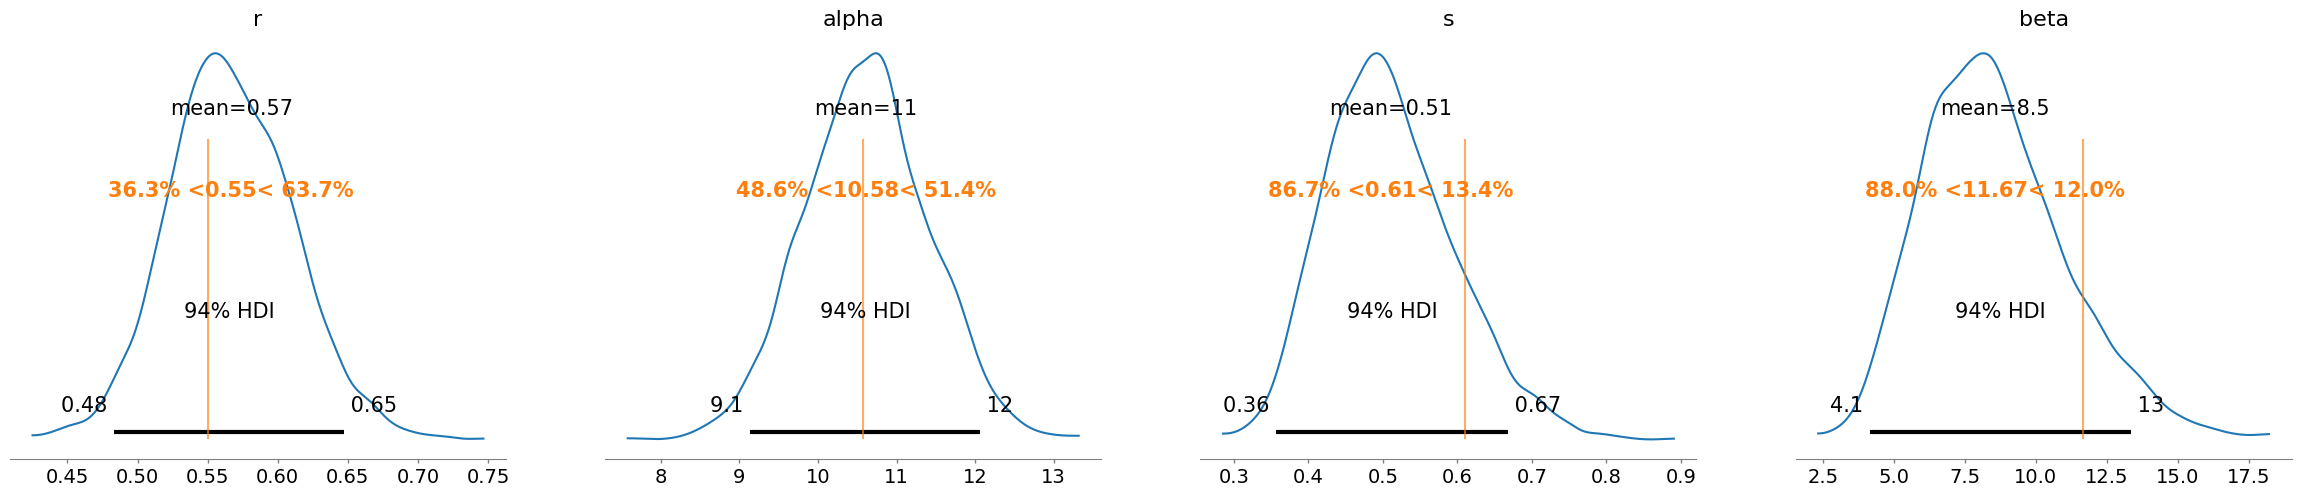

In [15]:
az.plot_posterior(idata, ref_val=list(fit.values()));

## Drawing from distribution (4 times as much data)

In [16]:
fit

{'r': 0.55, 'alpha': 10.58, 's': 0.61, 'beta': 11.67}

In [17]:
draws = pm.draw(ParetoNBD.dist(**fit, T=T.mean(), size=10_000))
draws

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [30.31116197,  1.        ],
       ...,
       [ 0.        ,  0.        ],
       [24.10603648,  4.        ],
       [ 0.        ,  0.        ]])

In [18]:
draws.shape

(10000, 2)

In [19]:
with pm.Model() as m2:
    r = pm.HalfNormal("r")
    alpha = pm.HalfNormal("alpha", sigma=5)
    s = pm.HalfNormal("s")
    beta = pm.HalfNormal("beta", sigma=5)
    ParetoNBD("llike", r=r, alpha=alpha, s=s, beta=beta, T=T.mean(), observed=draws)

In [20]:
with m2:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )        
        
        idata = pm.sample(initvals=fit, step=pm.Slice())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [r]
>Slice: [alpha]
>Slice: [s]
>Slice: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 226 seconds.


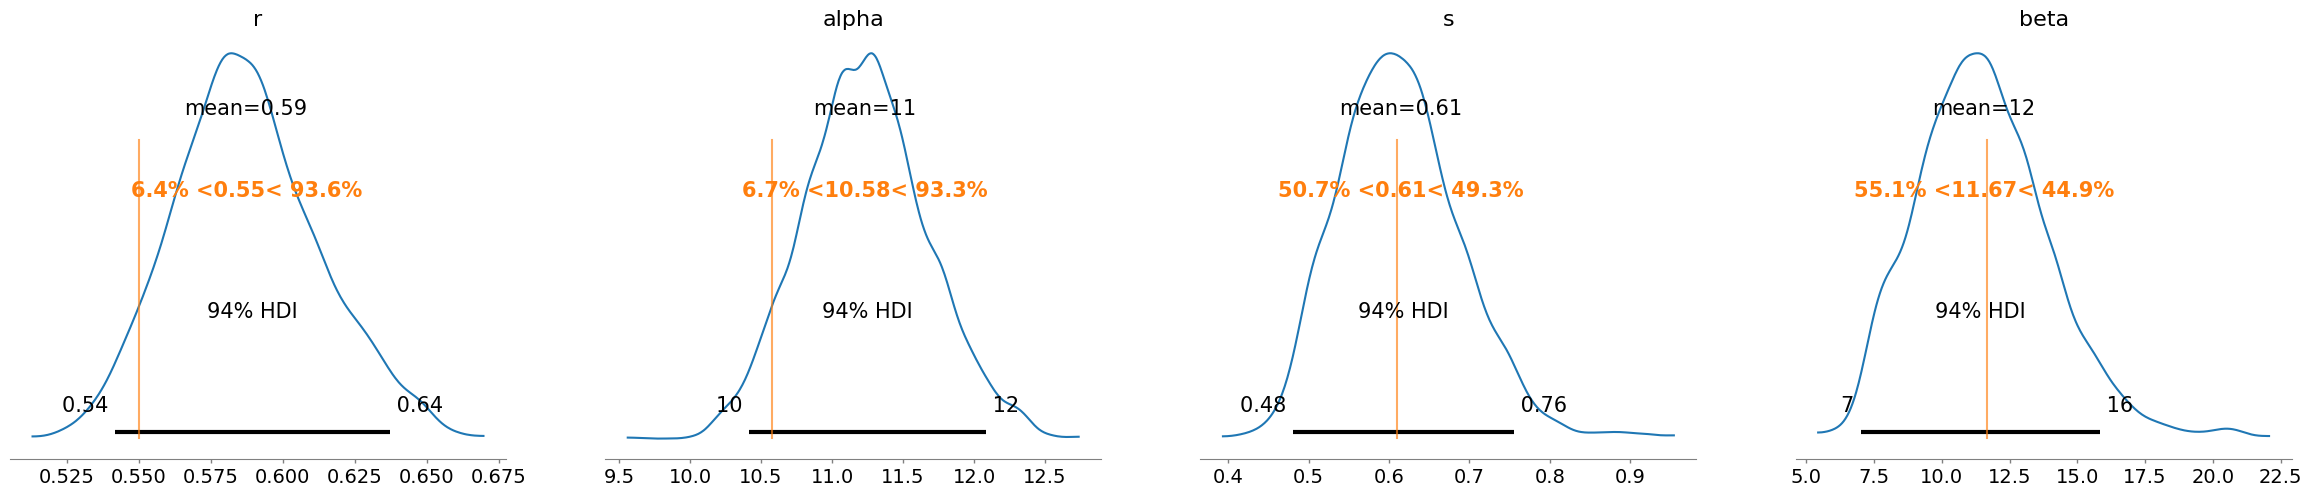

In [21]:
az.plot_posterior(idata, ref_val=list(fit.values()));

In [22]:
# with m2:
#     with warnings.catch_warnings():
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         warnings.filterwarnings(
#             action='ignore',
#             category=UserWarning,
#             message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
#         )   
        
#         idata = pm.sample(initvals=fit, init="adapt_diag")  # takes ages to sample

## Testing MAP

In [31]:
fit

{'r': 0.55, 'alpha': 10.58, 's': 0.61, 'beta': 11.67}

In [32]:
with m1:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )   
        
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )  
        res = pm.find_MAP()

In [33]:
{k: res[k] for k in fit}

{'r': array(0.56164462),
 'alpha': array(10.46574007),
 's': array(0.46757509),
 'beta': array(7.23078853)}

In [34]:
with m2:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )   
        
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Rewrite warning: The Op hyp2f1_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )  
        res = pm.find_MAP()

In [35]:
{k: res[k] for k in fit}

{'r': array(0.58406664),
 'alpha': array(11.16349162),
 's': array(0.5909339),
 'beta': array(10.81945176)}